In [1]:
from functools import partial
from itertools import product
import numpy as np
from plotnine import ggplot, geom_point, qplot, coord_fixed, aes
import polars as pl
from torch.distributions.dirichlet import Dirichlet
import torch
from scipy.sparse import coo_array
from scipy import linalg
import scipy.sparse.linalg as sparselinalg

import zstandard as zstd

## Set Up

The basic idea is to sample synthetic n-gram distributions, fit a language model to learn the distribution, and then analyze how the model represents n-gram information.

If there are $|V| = v$ "tokens" in the vocabulary then our n-gram model will be a Markov chain with a $v^n \times v^n$ transition matrix.

In [2]:
from itertools import starmap
from functools import partial

def in_base_vocab(n_vocab, *indices):
    base_sixteen = reversed([n_vocab**i for i in range(len(indices))])
    return sum([b * idx for (b, idx) in zip(base_sixteen, indices)])


In [3]:
from tokengrams import MemmapIndex, InMemoryIndex

/Users/dashiell/workspace/ngram-markov


In [4]:
from datasets import load_dataset

tinystories = load_dataset("roneneldan/TinyStories")

Repo card metadata block was not found. Setting CardData to empty.


In [5]:
from transformers import AutoTokenizer


old_tokenizer = AutoTokenizer.from_pretrained('tokenizer/tinystories512_with_pad')

In [6]:
from transformer_lens import HookedTransformer, HookedTransformerConfig

In [7]:
import json

old_tokenizer
#with open('tokenizer/tinystories512_with_pad/tokenizer.json') as cfg:
#    vocab = json.load(cfg)

GPTNeoXTokenizerFast(name_or_path='tokenizer/tinystories512_with_pad', vocab_size=512, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [8]:
from itertools import chain

def get_training_corpus(key):
    dataset = tinystories["train"]
    for start_idx in range(0, len(dataset), 1000):
        samples = dataset[start_idx : start_idx + 1000]
        yield samples["text"]

train_corp = get_training_corpus('train')
val_corp = get_training_corpus('validation')

In [9]:
def yield_from_dataset(dataset, key):
    for example in dataset[key]:
        yield example['text']

In [10]:
tokenizer = old_tokenizer.train_new_from_iterator(chain(train_corp, val_corp), 512)

In [13]:
tokenizer.save_pretrained('tokenizer/tinystories512/')

('tokenizer/tinystories512/tokenizer_config.json',
 'tokenizer/tinystories512/special_tokens_map.json',
 'tokenizer/tinystories512/tokenizer.json')

In [ ]:
from pathlib import Path

ts_bin_path = 'data/tinystories/tinystories_512_pythia_train_document.bin'


index = MemmapIndex.build(
    ts_bin_path,
    "data/tinystories_ngrams.idx",
    verbose=True
)

In [ ]:
index.save('data/tinystories_ngrams.idx')

In [30]:
queries = [[i] for i in range(512)]

after_hello = index.batch_count_next(queries, 511)

In [32]:
len(after_hello[0])

512

/Users/dashiell/workspace/ngram-markov/.venv/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 112'. Pick better value with 'binwidth'.
/Users/dashiell/workspace/ngram-markov/.venv/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 112'. Pick better value with 'binwidth'.


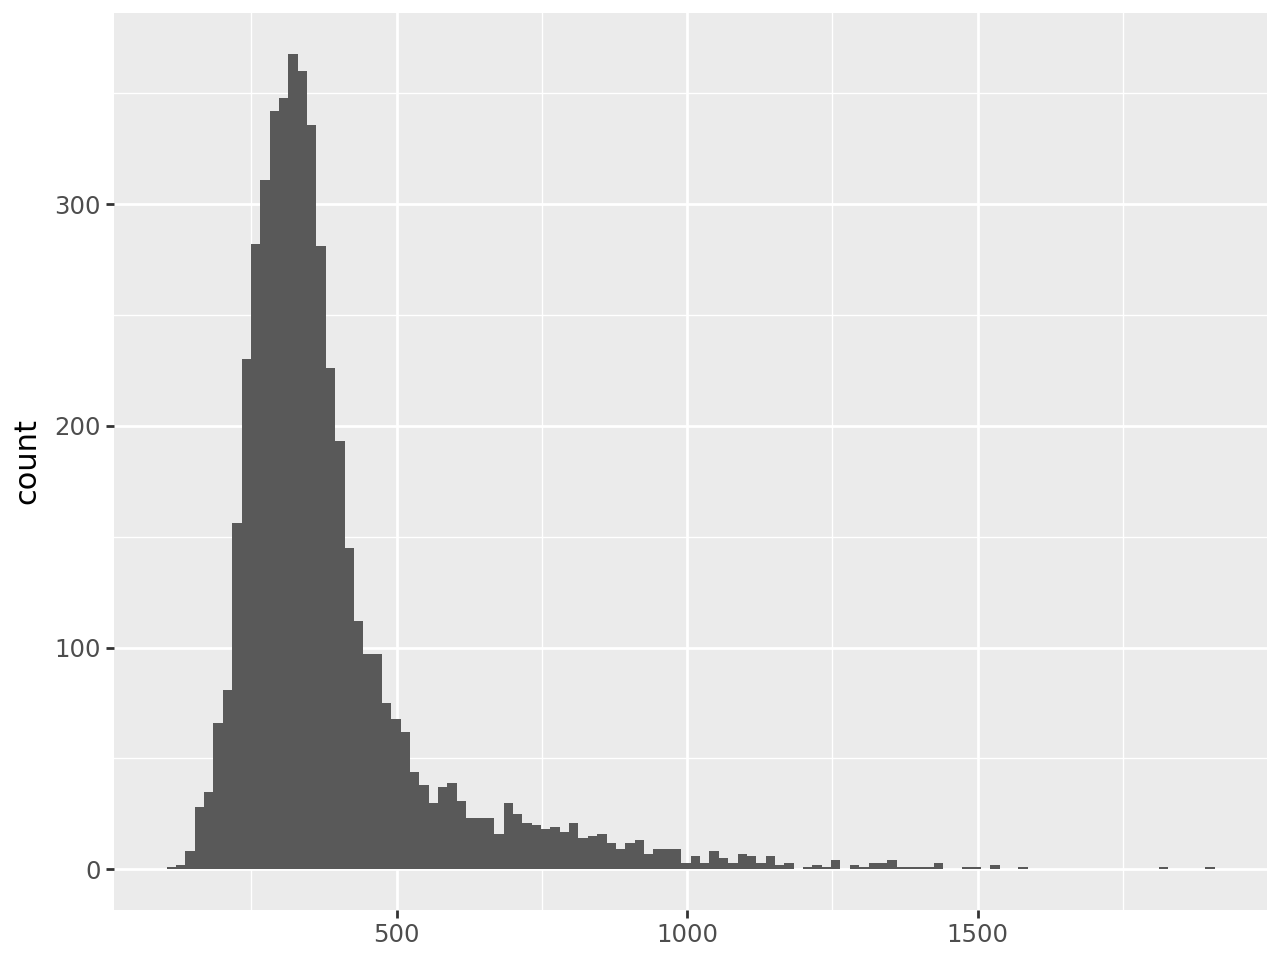

In [28]:
from plotnine import geom_histogram

qplot(x=lengths) + geom_histogram()

In [4]:
import pickle
from pathlib import Path

ngram_path = Path('pythia-deduped-bigrams.zst')

decomp = zstd.ZstdDecompressor()

with open(ngram_path, mode='rb') as file:
    raw_data = decomp.decompress(file.read())

In [5]:
bigrams = pickle.loads(raw_data)

<50277x50277 sparse array of type '<class 'numpy.uint32'>'
	with 486734660 stored elements in Compressed Sparse Row format>

/Users/dashiell/workspace/ngram-markov/.venv/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 305'. Pick better value with 'binwidth'.
/Users/dashiell/workspace/ngram-markov/.venv/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 305'. Pick better value with 'binwidth'.


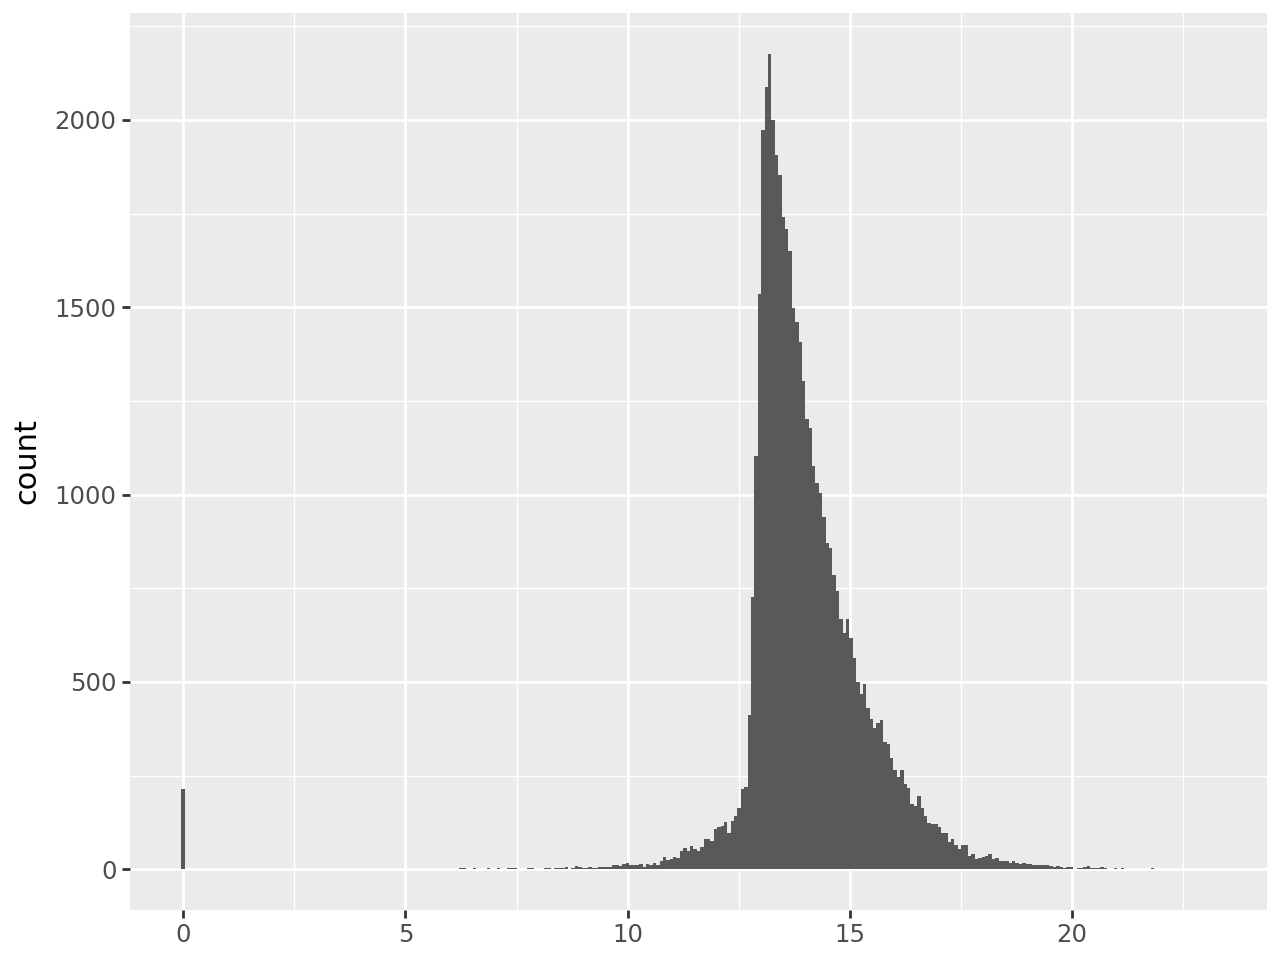

In [7]:
from plotnine import geom_histogram

transitions_from = np.sum(bigrams, axis=0)
qplot(x=np.log(1 + transitions_from)) + geom_histogram()

In [8]:
token_counts = pl.DataFrame({'occurrences': transitions_from}).with_row_index()

In [9]:
df = (
    token_counts
    .with_columns(
        pl.col('occurrences').rank(descending=True).alias('rank'),
        (pl.col('occurrences') + 1).log().alias('log_occurrences')
    )
    .with_columns(pl.col('rank').log().alias('log_rank'))
)

In [10]:
df.filter(pl.col('rank').lt(10))

index,occurrences,rank,log_occurrences,log_rank
u32,u64,f64,f64,f64
13,9362638615,3.0,22.959993,1.098612
14,2965935634,9.0,21.810458,2.197225
15,10346382453,2.0,23.059903,0.693147
187,11740996961,1.0,23.186353,0.0
247,3312842838,8.0,21.921073,2.079442
253,8485755698,4.0,22.861655,1.386294
273,4746582725,5.0,22.280691,1.609438
281,4084327341,7.0,22.130423,1.94591
285,4201626736,6.0,22.158738,1.791759


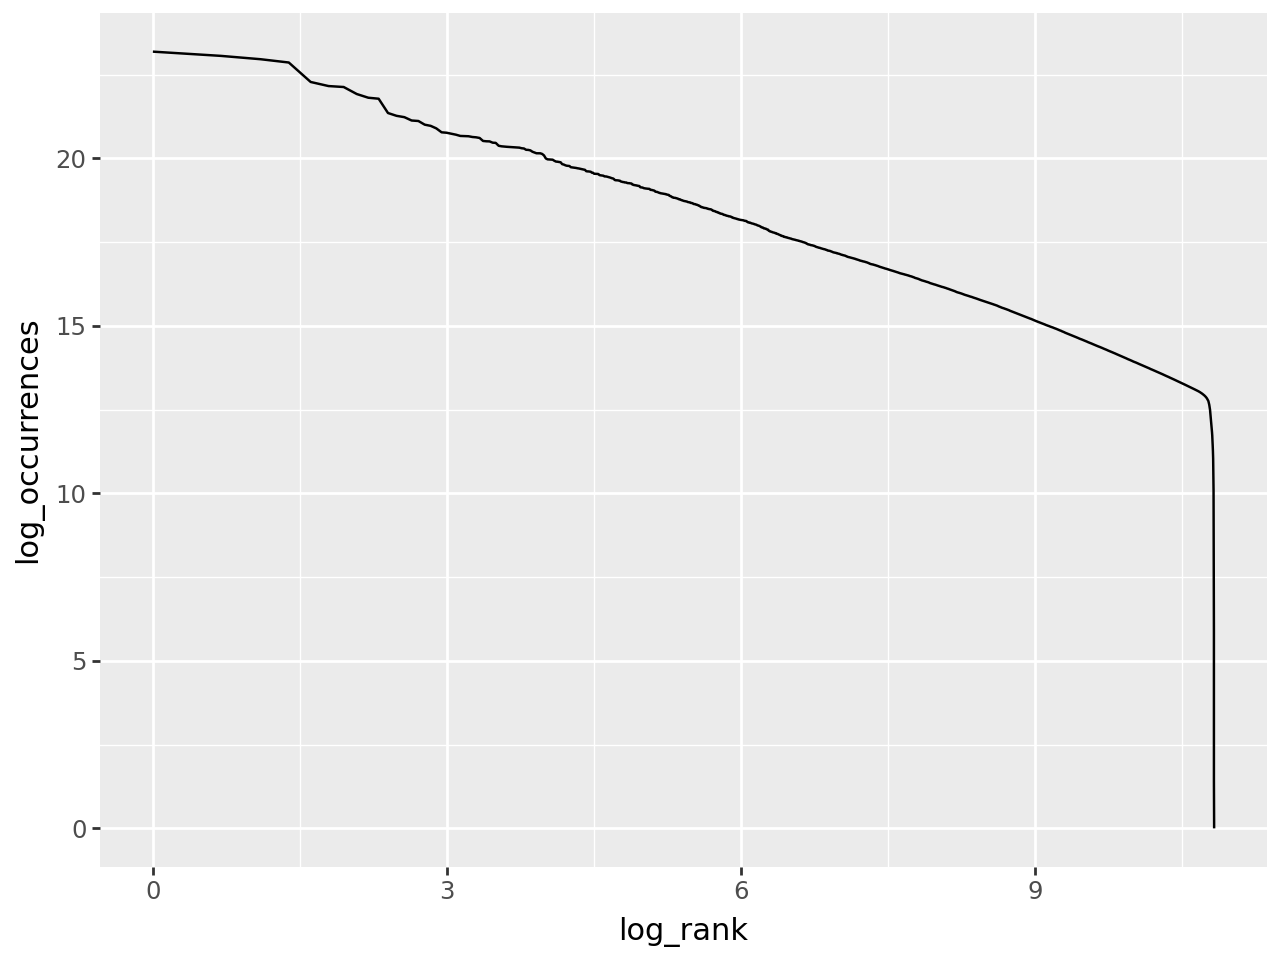

In [20]:
from plotnine import geom_line

ggplot(df, aes(x = 'log_rank', y='log_occurrences')) + geom_line()

/Users/dashiell/workspace/ngram-markov/.venv/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 305'. Pick better value with 'binwidth'.


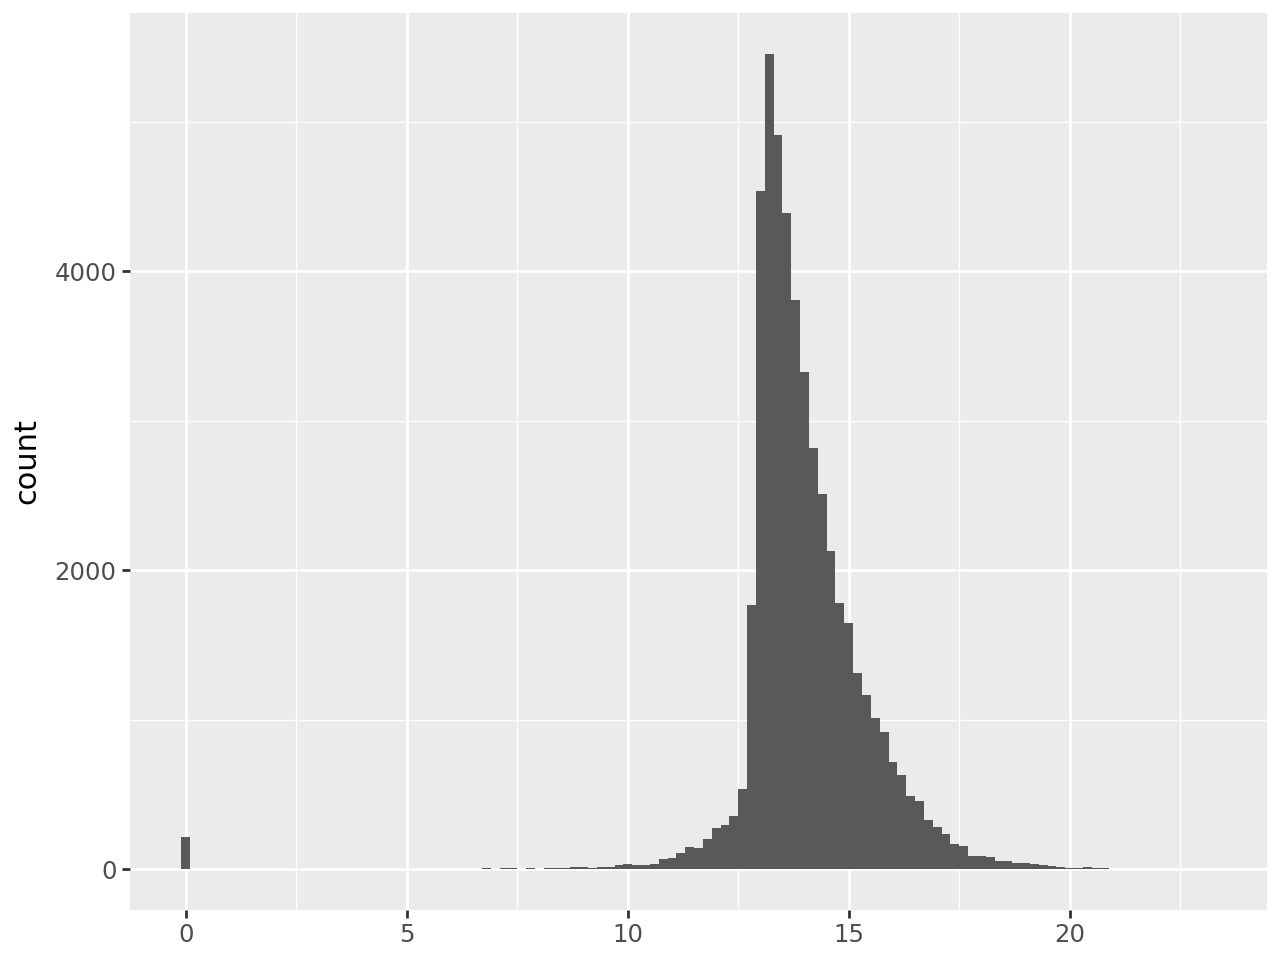

In [26]:

transitions_to = np.sum(bigrams, axis=1)
qplot(x=np.log(1 + transitions_to)) + geom_histogram(binwidth=0.2)

In [31]:
bigrams[[0], :].todense()

array([[0, 0, 0, ..., 0, 0, 0]], dtype=uint32)

In [11]:
occurrences = bigrams.sum(axis=0)
occurrences[occurrences == 0] += 1
occurrences

array([      166,         1, 157123247, ..., 615893065, 213319733,
       695610999], dtype=uint64)

In [12]:
bg = bigrams / occurrences[:, None]

In [ ]:
eigenvalues, eigenvectors = sparselinalg.eigs(bg, k=1000)

In [25]:
eigenvalues

array([ 3.4932413e+09+0.0000000e+00j,  5.2211235e+08+0.0000000e+00j,
       -1.3521040e+08+2.6957133e+08j, -1.3521040e+08-2.6957133e+08j,
       -3.0462666e+08+0.0000000e+00j,  1.4137466e+08+6.4938216e+07j,
        1.4137466e+08-6.4938216e+07j,  1.4795571e+08+0.0000000e+00j,
        1.1634638e+08+1.1600215e+07j,  1.1634638e+08-1.1600215e+07j],
      dtype=complex64)

In [32]:
50_000 ** 2

2500000000

In [30]:

vocab = 4
n = 4
n_states = vocab ** (n-1)
sparse = False

dist = Dirichlet(torch.ones((vocab,)))

base_vocab = partial(in_base_vocab, vocab)
suffixes = list(product(range(vocab), repeat=(n - 1)))
prefixes = sorted(suffixes, key=lambda x: tuple(reversed(x)))

prefix_suffix_mat = torch.block_diag(*dist.sample((n_states,)).split(vocab))
prefix_to_suffix_idx = list(starmap(base_vocab, prefixes))
transition_mat = prefix_suffix_mat[prefix_to_suffix_idx, :]

In [7]:
from scipy.sparse import coo_array
from scipy import linalg
import scipy.sparse.linalg as sparselinalg


if sparse:
    transition_mat = transition_mat.to_sparse()
    rows, cols = np.split(transition_mat.indices().numpy(), 2)
    rows = rows[0]
    cols = cols[0]
    vals = transition_mat.values().numpy()
    transition_np = coo_array((vals, (rows, cols)), shape=(n_states, n_states))
    eigenvalues, _ = linalg.eigs(transition_np, k=1_000)
else:
    eigenvalues = linalg.eigvals(transition_mat.numpy())


data = pl.DataFrame({
    'real': eigenvalues.real,
    'imaginary': eigenvalues.imag,
    'type': ['eig']* len(eigenvalues)
})
    


In [9]:
def sample_eigenvalues(vocab, n, sparse=False):
    n_states = vocab ** (n - 1)

    dist = Dirichlet(torch.ones((vocab,)))
    
    base_vocab = partial(in_base_vocab, vocab)
    suffixes = list(product(range(vocab), repeat=(n-1)))
    prefixes = sorted(suffixes, key=lambda x: tuple(reversed(x)))
    
    prefix_suffix_mat = torch.block_diag(*dist.sample((n_states,)).split(vocab))
    prefix_to_suffix_idx = list(starmap(base_vocab, prefixes))
    transition_mat = prefix_suffix_mat[prefix_to_suffix_idx, :]
    
    if sparse:
        transition_mat = transition_mat.to_sparse()
        rows, cols = np.split(transition_mat.indices().numpy(), 2)
        rows = rows[0]
        cols = cols[0]
        vals = transition_mat.values().numpy()
        transition_np = coo_array((vals, (rows, cols)), shape=(n_states, n_states))
        eigenvalues, _ = linalg.eigs(transition_np, k=1_000)
    else:
        eigenvalues = torch.linalg.eigvals(transition_mat)
    return eigenvalues
            
    

In [10]:
4 ** 7

16384

In [26]:
from tqdm.notebook import tqdm, trange

all_data = []

for _ in trange(5000):
    eigvals = sample_eigenvalues(512, 2)
    #print(torch.count_nonzero(eigvals.imag))
    data = pl.DataFrame({'real': eigvals.real.numpy(), 'imaginary': eigvals.imag.numpy()})
    all_data.append(data)
df = pl.concat(all_data)

  0%|          | 0/5000 [00:00<?, ?it/s]

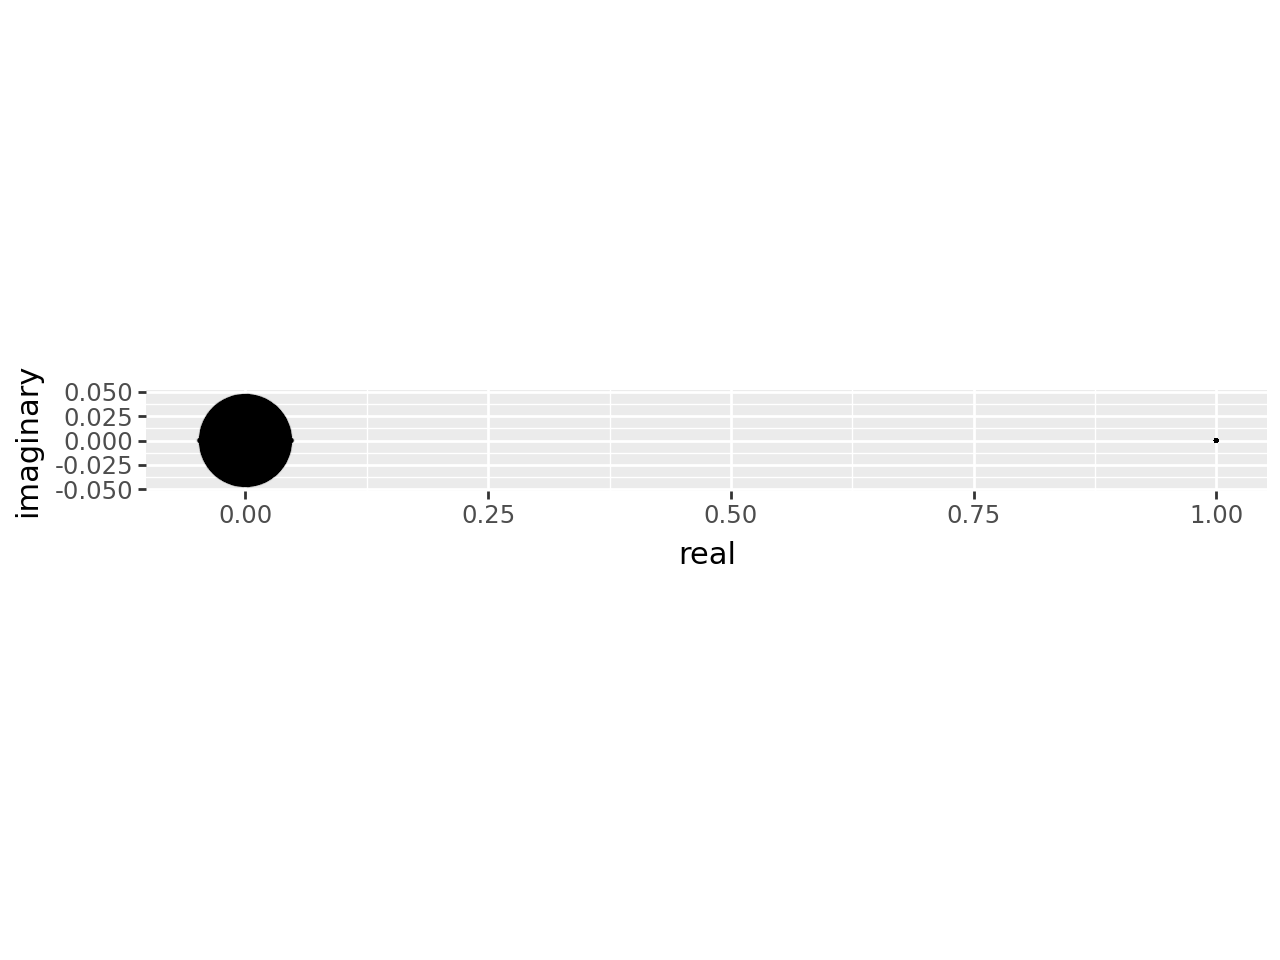

In [28]:
import numpy as np
from plotnine import annotate

theta = np.linspace(0, 2 * np.pi, 5000)

unit_circle = annotate(
    "path",
    x=np.cos(theta),
    y=np.sin(theta),
    color='darkblue'
)

ggplot(df, aes(x='real', y='imaginary')) + geom_point(size=0.001, alpha=0.01) + coord_fixed()

In [228]:
from functools import partial
from collections import deque
import numpy as np

def vocab_to_idx_generator(n_vocab, *indices):
    base_sixteen = reversed([n_vocab**i for i in range(len(indices))])
    return sum([b * idx for (b, idx) in zip(base_sixteen, indices)])


def project_probabilities(probs, unigram_probs):
    """
    Uses the algorithm of alternating between making the rows stochastic (sum to 1.) and columns sum to `unigram_probs`,
    an adaptation of the algorithm described here to generate random bistochastic matrices: https://iopscience.iop.org/article/10.1088/1751-8113/42/36/365209
    Does not end up sampling from the Haar measure on bistochastic matrices, but it converges very quickly.
    """
    curr_sums = probs.sum(axis=0)
    temp_probs = probs * (unigram_probs / curr_sums)[None, :]
    temp_sums = temp_probs.sum(axis=1)[:, None]
    return temp_probs / temp_sums


class NgramSampler:
    
    zipf_epsilon = 1.e-5
    zipf_max_iter = 20

    """
    
    """
    def __init__(self, num_vocab: int, n: int, transition_probs, rng = None):
        self.n = n
        self.zipf_alpha = zipf_alpha
        self.num_vocab = num_vocab
        self.num_states = num_vocab ** (n - 1)
        self.transition_probs = transition_probs
        self.unigram_probs = transition_probs.sum(axis=0) / self.num_states
        self.rng = rng if rng is not None else np.random.default_rng()
        self.vocab_idx_fn = partial(vocab_to_idx_generator, num_vocab)
        assert transition_probs.shape == (self.num_states, self.num_vocab), (self.num_states, self.num_vocab)

        self._state = deque()

    @classmethod
    def sample_zipfian_distribution(cls, num_vocab: int, n: int, zip_alpha: float, rng = None):
        if rng is None:
            rng = np.random.default_rng()
        num_states = num_vocab ** (n - 1)
        transition_probs = rng.dirichlet(np.ones((num_vocab,)), size=(num_states,))
        zipf_probs = (np.arange(num_vocab) + 1) ** (-1 * zipf_alpha)
        zipf_probs /= zipf_probs.sum()
        curr_unigram_probs = transition_probs.sum(axis=0) / num_states
        i = 0
        while not np.allclose(curr_unigram_probs, zipf_probs, atol=cls.zipf_epsilon):
            if i >= cls.zipf_max_iter:
                raise ValueError('Distribution did not converge to Zipfian on unigrams')
            transition_probs = project_probabilities(transition_probs, zipf_probs)
            curr_unigram_probs = transition_probs.sum(axis=0) / num_states
            i += 1
        return cls(num_vocab, n, transition_probs)

    def clear_state(self):
        self._state.clear()

        
    def sample(self, history=None):
        if len(self._state) < (self.n - 1):
            a = self.rng.choice(self.num_vocab, p=self.unigram_probs)
            self._state.append(a)
            return a
        else:
            idx = self.vocab_idx_fn(*tuple(self._state))
            a = self.rng.choice(self.num_vocab, p=self.transition_probs[idx])
            self._state.append(a)
            self._state.popleft()
            return a


In [161]:
zipfian = NgramSampler.sample_zipfian_distribution(32, 2, 1.5)

In [229]:
import torch
from torch.utils.data import IterableDataset, DataLoader


class NgramDataset(IterableDataset):
    def __init__(self, num_vocab, n, zipf_alpha, seq_len, seed, worker_id=None):
        super().__init__()
        self.num_vocab = num_vocab
        self.n = n
        self.zipf_alpha = zipf_alpha
        self.seq_len = seq_len
        self.worker_id = worker_id
        self.seed = seed

    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None:
            # Single-process data loading
            rng = np.random.default_rng(self.seed)
        else:
            # Multi-process data loading
            worker_id = worker_info.id
            rng = np.random.default_rng(self.seed + worker_id)

        sampler = NgramSampler.sample_zipfian_distribution(self.num_vocab, self.n, self.zipf_alpha, rng)
        while True:
            sequence = [self.num_vocab] + [sampler.sample() for _ in range(self.seq_len)]
            sampler.clear_state()
            yield torch.tensor(sequence, dtype=torch.long)

In [230]:
ngram_data = NgramDataset(32, 5, 1, 128, 0)

In [231]:
data = iter(ngram_data)

next(data)

tensor([32,  0,  0,  2,  2,  0, 18,  0,  0,  2,  0, 12,  9,  1,  0,  1,  0,  6,
        12, 27,  0,  7,  0,  3,  8, 14,  1,  3,  1,  6,  0,  2,  0,  1,  1,  0,
         0,  1,  3,  0,  7,  0,  4,  1,  1,  0,  9,  7,  0,  3,  1,  5,  0, 11,
         0,  1,  0,  4,  0,  3,  0,  0,  0,  0, 12,  1,  0,  0,  0,  2,  7,  1,
         0,  0,  6,  0,  1,  1,  6,  3,  1,  0,  0,  0, 20,  3,  0,  8,  3,  1,
         1,  0,  6,  2,  0,  0,  0,  0,  0,  1,  9,  8, 17,  1,  0,  2,  0, 14,
         4,  8, 30,  7,  0, 13, 22,  0,  2,  1,  1,  8,  0,  0,  3,  0,  3,  0,
         0,  2, 16])

In [264]:
next(data)

tensor([32,  1,  2,  0,  0,  0,  1,  0,  7,  0,  0, 16,  1,  0, 26,  0,  0,  3,
         5, 23,  3, 10,  0,  5,  0,  0,  2,  3,  0,  0,  1,  5,  0,  1,  1,  3,
         0,  0,  6,  2,  0,  0,  0,  1, 11,  3,  0,  0,  3,  1,  0,  6,  1,  0,
         0, 20,  2,  3, 14, 30,  2,  6,  2,  0,  3,  0,  0,  0,  3,  0,  0,  0,
        15,  5,  2,  1, 17,  0,  0,  0,  0,  9, 16,  2,  4,  6,  2,  3,  7,  1,
         7,  3,  1,  0,  7,  0,  3,  1,  0,  0,  0,  7, 25,  0,  0,  0, 18,  3,
         2,  0, 19,  0,  1, 13,  9,  2,  0,  6,  4,  1,  0, 20,  0, 31,  8,  6,
         5, 15,  7])

In [187]:
n = 32
zipf_alpha = 1.4
unigram_probs = (np.arange(n) + 1) ** (-1 * zipf_alpha)
unigram_probs /= unigram_probs.sum()

In [69]:
unigram_probs

array([0.40250761, 0.15252186, 0.08645783, 0.05779498, 0.0422879 ,
       0.03276139, 0.026402  , 0.0219002 , 0.01857097, 0.01602412,
       0.01402246, 0.01241425, 0.01109822, 0.01000449, 0.00908336,
       0.00829862, 0.00762335, 0.00703708, 0.00652408, 0.006072  ,
       0.0056711 , 0.00531352, 0.00499293, 0.00470412, 0.00444281,
       0.00420544, 0.00398901, 0.00379099, 0.00360925, 0.00344195,
       0.00328751, 0.00314459])

In [70]:
probs = rng.dirichlet(np.ones((32,)), size=(32,))


In [75]:
curr_sums = probs.sum(axis=0)

In [136]:
def project_probabilities(probs, unigram_probs):
    curr_sums = probs.sum(axis=0)
    temp_probs = probs * (unigram_probs / curr_sums)[None, :]
    temp_sums = temp_probs.sum(axis=1)[:, None]
    return temp_probs / temp_sums

In [102]:
projected = project_probabilities(probs)
projected

array([[5.81407568e-01, 1.24071567e-02, 6.19643239e-02, ...,
        3.46352701e-03, 5.30976845e-03, 3.60757669e-03],
       [2.32788189e-01, 1.05208514e-01, 1.30564712e-01, ...,
        5.24477355e-04, 1.28459021e-02, 7.57222420e-03],
       [6.16415567e-02, 3.28289578e-01, 1.10981670e-02, ...,
        3.31860282e-03, 3.07830453e-04, 3.62350016e-05],
       ...,
       [1.72416671e-01, 3.52783853e-01, 2.51139470e-02, ...,
        1.34777752e-02, 4.83724436e-04, 6.27315764e-03],
       [3.83264252e-01, 1.99864245e-02, 2.25705397e-01, ...,
        9.94934623e-03, 2.29166866e-03, 3.10788021e-03],
       [2.85721072e-01, 2.16908460e-01, 7.90821628e-02, ...,
        7.17366488e-03, 1.24500831e-02, 9.85381950e-04]])

In [137]:
proj1 = project_probabilities(probs, unigram_probs)
proj2 = project_probabilities(proj1, unigram_probs)
proj3 = project_probabilities(proj2, unigram_probs)
proj4 = project_probabilities(proj3, unigram_probs)
proj5 = project_probabilities(proj4, unigram_probs)

In [138]:
proj1[0, :].sum()

1.0

In [142]:
proj4.sum(axis=0) / 32

array([0.40018907, 0.15348512, 0.08665207, 0.05796336, 0.04233004,
       0.03300237, 0.02650799, 0.02196802, 0.01861298, 0.01605425,
       0.01407421, 0.0124324 , 0.01113962, 0.01004945, 0.00913821,
       0.00832182, 0.00765816, 0.00705942, 0.00654076, 0.00609567,
       0.00568137, 0.0053202 , 0.00500511, 0.00471766, 0.0044503 ,
       0.00421976, 0.0040067 , 0.00380413, 0.00362467, 0.00345403,
       0.00329484, 0.00314626])

In [127]:
unigram_probs

array([0.40250761, 0.15252186, 0.08645783, 0.05779498, 0.0422879 ,
       0.03276139, 0.026402  , 0.0219002 , 0.01857097, 0.01602412,
       0.01402246, 0.01241425, 0.01109822, 0.01000449, 0.00908336,
       0.00829862, 0.00762335, 0.00703708, 0.00652408, 0.006072  ,
       0.0056711 , 0.00531352, 0.00499293, 0.00470412, 0.00444281,
       0.00420544, 0.00398901, 0.00379099, 0.00360925, 0.00344195,
       0.00328751, 0.00314459])

In [77]:
theta = np.linspace(0, 2 * np.pi, 5000)
circle_x = np.cos(theta)
circle_y = np.sin(theta)


circle_plot =  

SyntaxError: invalid syntax (3919872837.py, line 6)

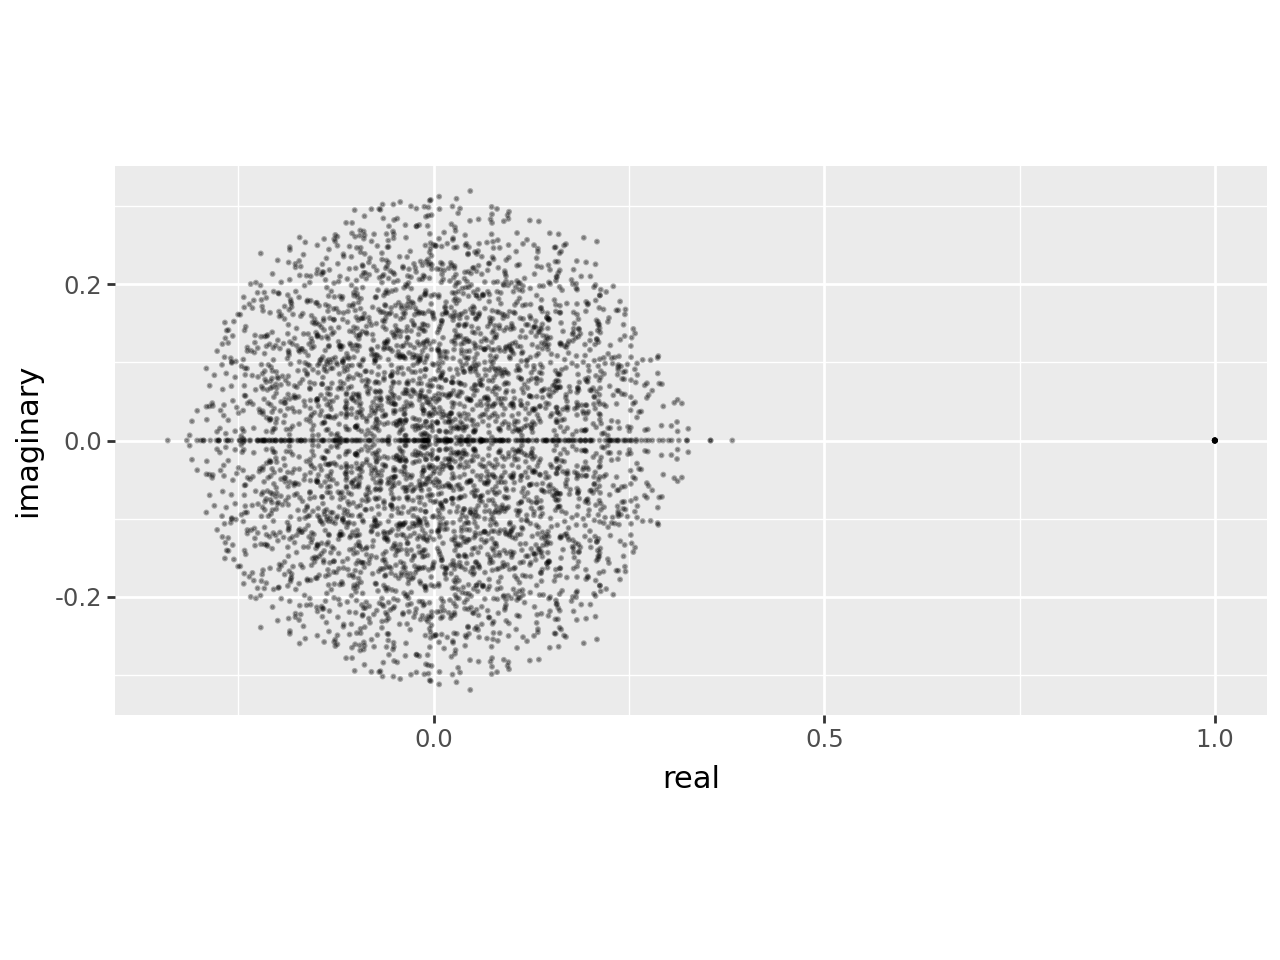